# Dog vs Cat Classification

## Introduction

Kaggle competition: https://www.kaggle.com/competitions/dog-vs-cat-classification/

In this competition, the competitor is tasked with writing a script to classify whether an image contains a dog or a cat. I have chosen to approach this challenge using a CNN, which is a reliable deep learning algorithm used for image classification. 

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPooling2D, MaxPool2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from glob import glob
from PIL import Image
import os

In [2]:
path = "/Users/clairerobbins/Documents/MS-DS CU Boulder/Introduction to Deep Learning/Final Project/dog-vs-cat-classification/" 
cat_path = path + 'train/cats'
dog_path = path + 'train/dogs'
test_path = path + 'test/test'

## Data Preprocessing & EDA

In [3]:
cats = pd.DataFrame({'path': glob(os.path.join(cat_path,'*.jpg'))})
cats['id'] = [os.path.basename(i) for i in cats['path']]
cat_labels = [0 for i in range(len(cats))]
cats['label'] = cat_labels
cats.head(5)

,path,id,label
0,/Users/clairerobbins/Documents/MS-DS CU Boulde...,cat.5077.jpg,0
1,/Users/clairerobbins/Documents/MS-DS CU Boulde...,cat.2718.jpg,0
2,/Users/clairerobbins/Documents/MS-DS CU Boulde...,cat.10151.jpg,0
3,/Users/clairerobbins/Documents/MS-DS CU Boulde...,cat.3406.jpg,0
4,/Users/clairerobbins/Documents/MS-DS CU Boulde...,cat.4369.jpg,0


In [4]:
dogs = pd.DataFrame({'path': glob(os.path.join(dog_path,'*.jpg'))})
dogs['id'] = [os.path.basename(i) for i in dogs['path']]
dog_labels = [1 for i in range(len(dogs))]
dogs['label'] = dog_labels
dogs.head(5)

,path,id,label
0,/Users/clairerobbins/Documents/MS-DS CU Boulde...,dog.8011.jpg,1
1,/Users/clairerobbins/Documents/MS-DS CU Boulde...,dog.7322.jpg,1
2,/Users/clairerobbins/Documents/MS-DS CU Boulde...,dog.1753.jpg,1
3,/Users/clairerobbins/Documents/MS-DS CU Boulde...,dog.5535.jpg,1
4,/Users/clairerobbins/Documents/MS-DS CU Boulde...,dog.3144.jpg,1


In [5]:
dfs = [cats, dogs]
train = pd.concat(dfs)
train.head(5)

,path,id,label
0,/Users/clairerobbins/Documents/MS-DS CU Boulde...,cat.5077.jpg,0
1,/Users/clairerobbins/Documents/MS-DS CU Boulde...,cat.2718.jpg,0
2,/Users/clairerobbins/Documents/MS-DS CU Boulde...,cat.10151.jpg,0
3,/Users/clairerobbins/Documents/MS-DS CU Boulde...,cat.3406.jpg,0
4,/Users/clairerobbins/Documents/MS-DS CU Boulde...,cat.4369.jpg,0


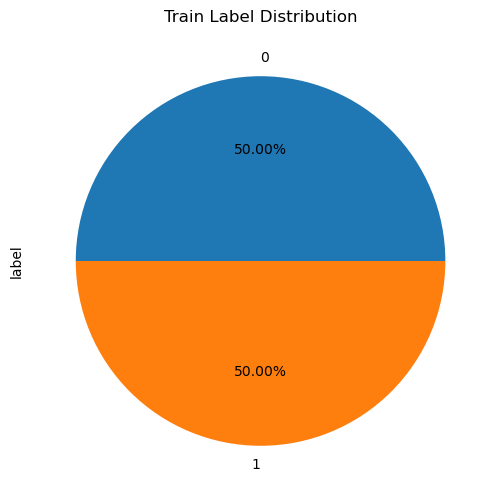

In [6]:
train['label'].value_counts().plot(figsize=(6,6),kind='pie',autopct='%.2f%%')
plt.title('Train Label Distribution')
plt.show()

In [7]:
test = pd.DataFrame({'path': glob(os.path.join(test_path,'*.jpg'))})
test['id'] = [os.path.basename(i) for i in test['path']]
test['label'] = [None for i in range(len(test))]
test

,path,id,label
0,/Users/clairerobbins/Documents/MS-DS CU Boulde...,003301.jpg,None
1,/Users/clairerobbins/Documents/MS-DS CU Boulde...,005770.jpg,None
2,/Users/clairerobbins/Documents/MS-DS CU Boulde...,001516.jpg,None
3,/Users/clairerobbins/Documents/MS-DS CU Boulde...,006279.jpg,None
4,/Users/clairerobbins/Documents/MS-DS CU Boulde...,007167.jpg,None
...,...,...,...
7995,/Users/clairerobbins/Documents/MS-DS CU Boulde...,006260.jpg,None
7996,/Users/clairerobbins/Documents/MS-DS CU Boulde...,005769.jpg,None
7997,/Users/clairerobbins/Documents/MS-DS CU Boulde...,002006.jpg,None
7998,/Users/clairerobbins/Documents/MS-DS CU Boulde...,003318.jpg,None


In [8]:
train, validate = train_test_split(train, test_size=0.2)

In [9]:
def clean_files(df):
    raw_data = []
    labels = []
    count = 0
    for index,row in df.iterrows():
        img = Image.open(row['path'])
        img = img.resize((224, 224), Image.ANTIALIAS)  # Resizing
        raw_data.append(img)
        labels.append(row['label'])
        count+=1
    return raw_data, labels

In [10]:
train_raw, train_labels = clean_files(train)
validate_raw, validate_labels = clean_files(validate)
test_raw, test_labels = clean_files(test)

/var/folders/5c/fd850vrj48v7jb6xpw9dy4v00000gn/T/ipykernel_3293/1186364363.py:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((224, 224), Image.ANTIALIAS)  # Resizing


In [11]:
train_raw2 = []
for i in train_raw:
    train_raw2.append(np.array(i))

validate_raw2 = []
for i in validate_raw:
    validate_raw2.append(np.array(i))
    
test_raw2 = []
for i in test_raw:
    test_raw2.append(np.array(i))

## Model Building & Training

I built my model with the following specs:

- kernel size = (3, 3): a very average kernel size to capture a medium amount of detail
- pool size = (2, 2): a normal pool size to start with
- 3 layers + dense layer
- relu activation: mitigate vanishing gradient, common activation function
- binary crossentropy activation function: standard choice for binary classification
- adam optimizer: adaptive optimizer, typically best optimizer to start with

In [12]:
kernel_size = (3, 3)
pool_size = (2, 2)
first_filters = 16
second_filters = 32
third_filters = 64

dropout_conv = 0.2
dropout_dense = 0.4

model = Sequential()

# Conv layer 1
model.add(Conv2D(first_filters, kernel_size, input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

# Conv layer 2
model.add(Conv2D(second_filters, kernel_size))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

# Conv layer 3
model.add(Conv2D(third_filters, kernel_size))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

# Fully connected (dense) layer
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))

# Activation function
model.add(Dense(1, activation="sigmoid"))

batch_size = 64
model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 16)      64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 222, 222, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4

In [13]:
history = model.fit(np.array(train_raw2), np.array(train_labels), epochs=10,
          validation_data=(np.array(validate_raw2), np.array(validate_labels)))

Epoch 1/10
625/625 [==============================] - 139s 221ms/step - loss: 0.5955 - accuracy: 0.6896 - val_loss: 0.5644 - val_accuracy: 0.7184
Epoch 2/10
625/625 [==============================] - 138s 221ms/step - loss: 0.4769 - accuracy: 0.7721 - val_loss: 0.4912 - val_accuracy: 0.7634
Epoch 3/10
625/625 [==============================] - 136s 217ms/step - loss: 0.4062 - accuracy: 0.8140 - val_loss: 0.8535 - val_accuracy: 0.6276
Epoch 4/10
625/625 [==============================] - 136s 218ms/step - loss: 0.3611 - accuracy: 0.8352 - val_loss: 0.4144 - val_accuracy: 0.8088
Epoch 5/10
625/625 [==============================] - 136s 218ms/step - loss: 0.3183 - accuracy: 0.8626 - val_loss: 0.4390 - val_accuracy: 0.8036
Epoch 6/10
625/625 [==============================] - 136s 217ms/step - loss: 0.2770 - accuracy: 0.8847 - val_loss: 0.5806 - val_accuracy: 0.7556
Epoch 7/10
625/625 [==============================] - 136s 217ms/step - loss: 0.2347 - accuracy: 0.9036 - val_loss: 0.6711 -

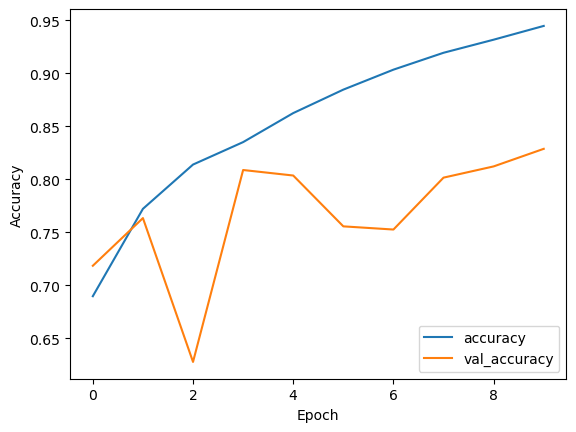

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

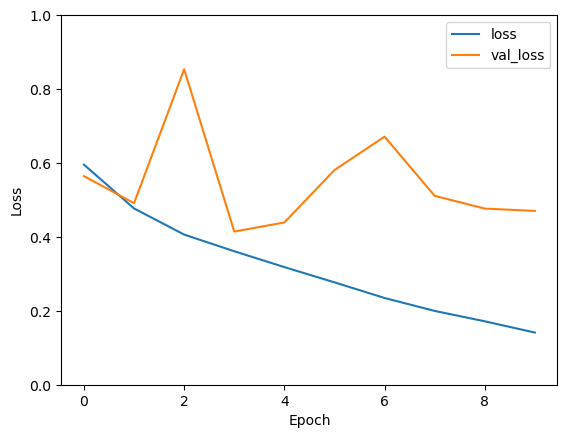

In [15]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 1])
plt.legend(loc='upper right');

In [16]:
predictions = model.predict(np.array(test_raw2))

250/250 [==============================] - 13s 51ms/step


In [17]:
# convert prediction percentages to binary classification
final_predictions = []
for i in predictions:
    if i > 0.5:
        final_predictions.append(1)
    else:
        final_predictions.append(0)

In [18]:
# generate submission file
submission = pd.DataFrame({'id': test['id'], 'label': final_predictions})
submission.set_index('id')
submission.to_csv('submission.csv')

## Conclusion

Despite the questionable validation accuracy and loss, my model performed quite well on the test data with 93% accuracy! After much trial and error, I landed on a model that is quite standard and not very fine-tuned, as I found it performed the best. I struggled to minimize my validation loss, something that I will continue to research and learn.